# gen3-opfb

This notebook tests the functionality of the gen3-opfb and builds upon concepts and patterns in the component test notebooks and various PYNQ examples.

The overlay looks like 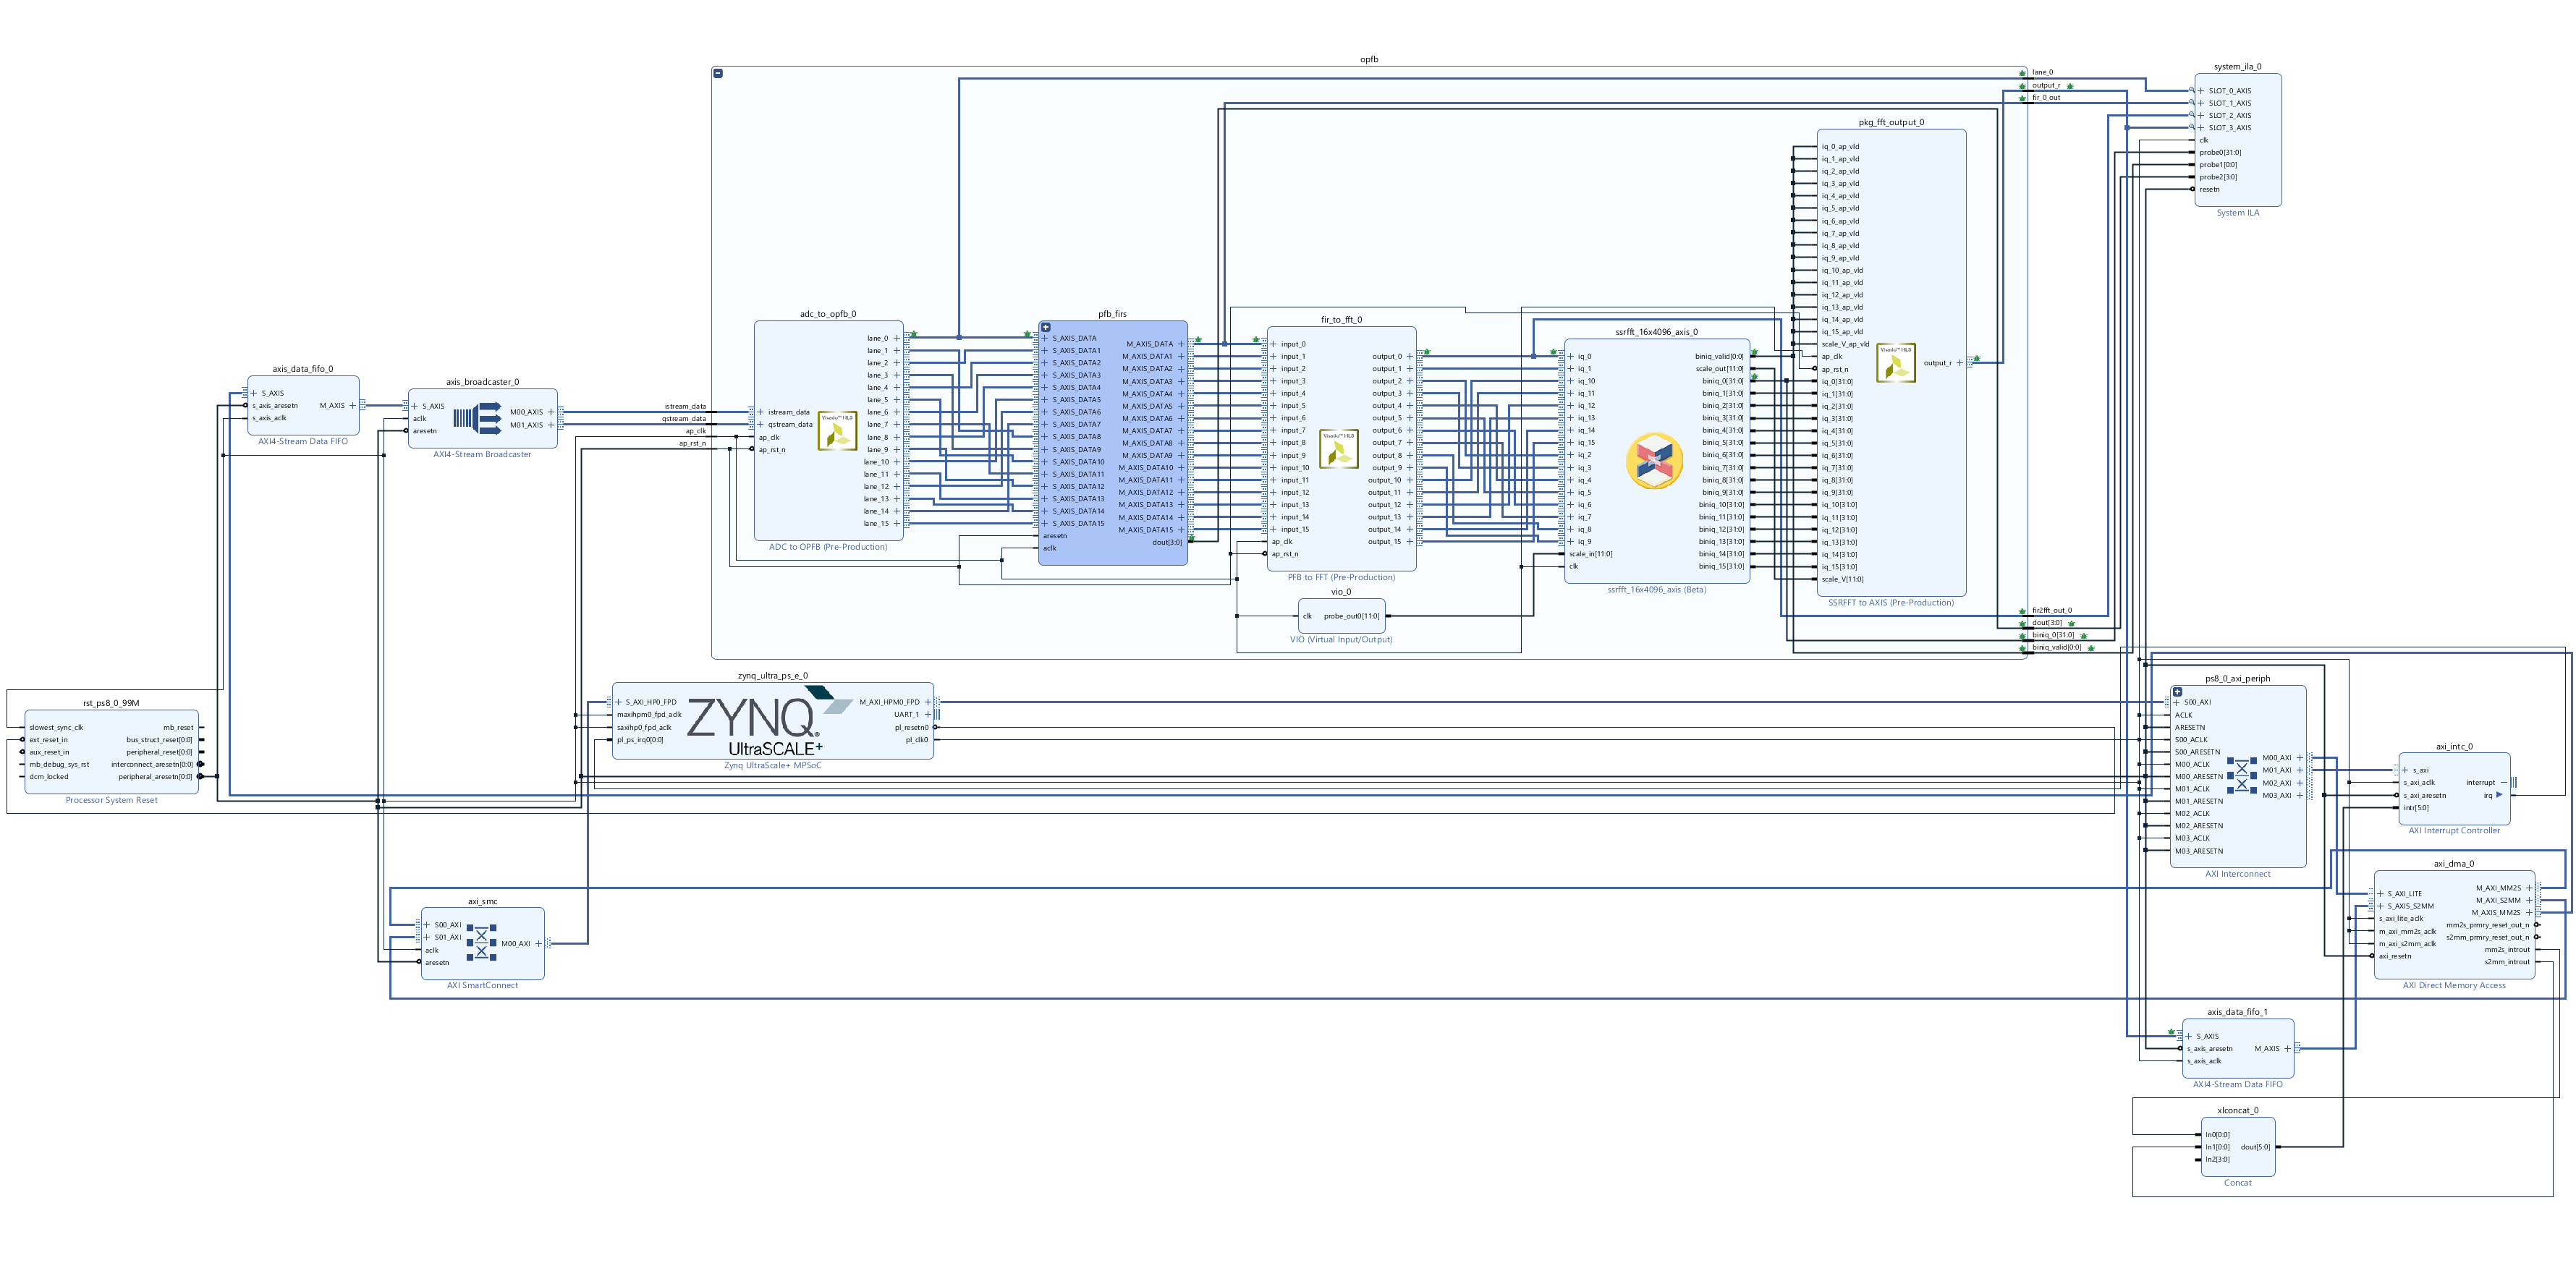

The OPFB subsystem looks like 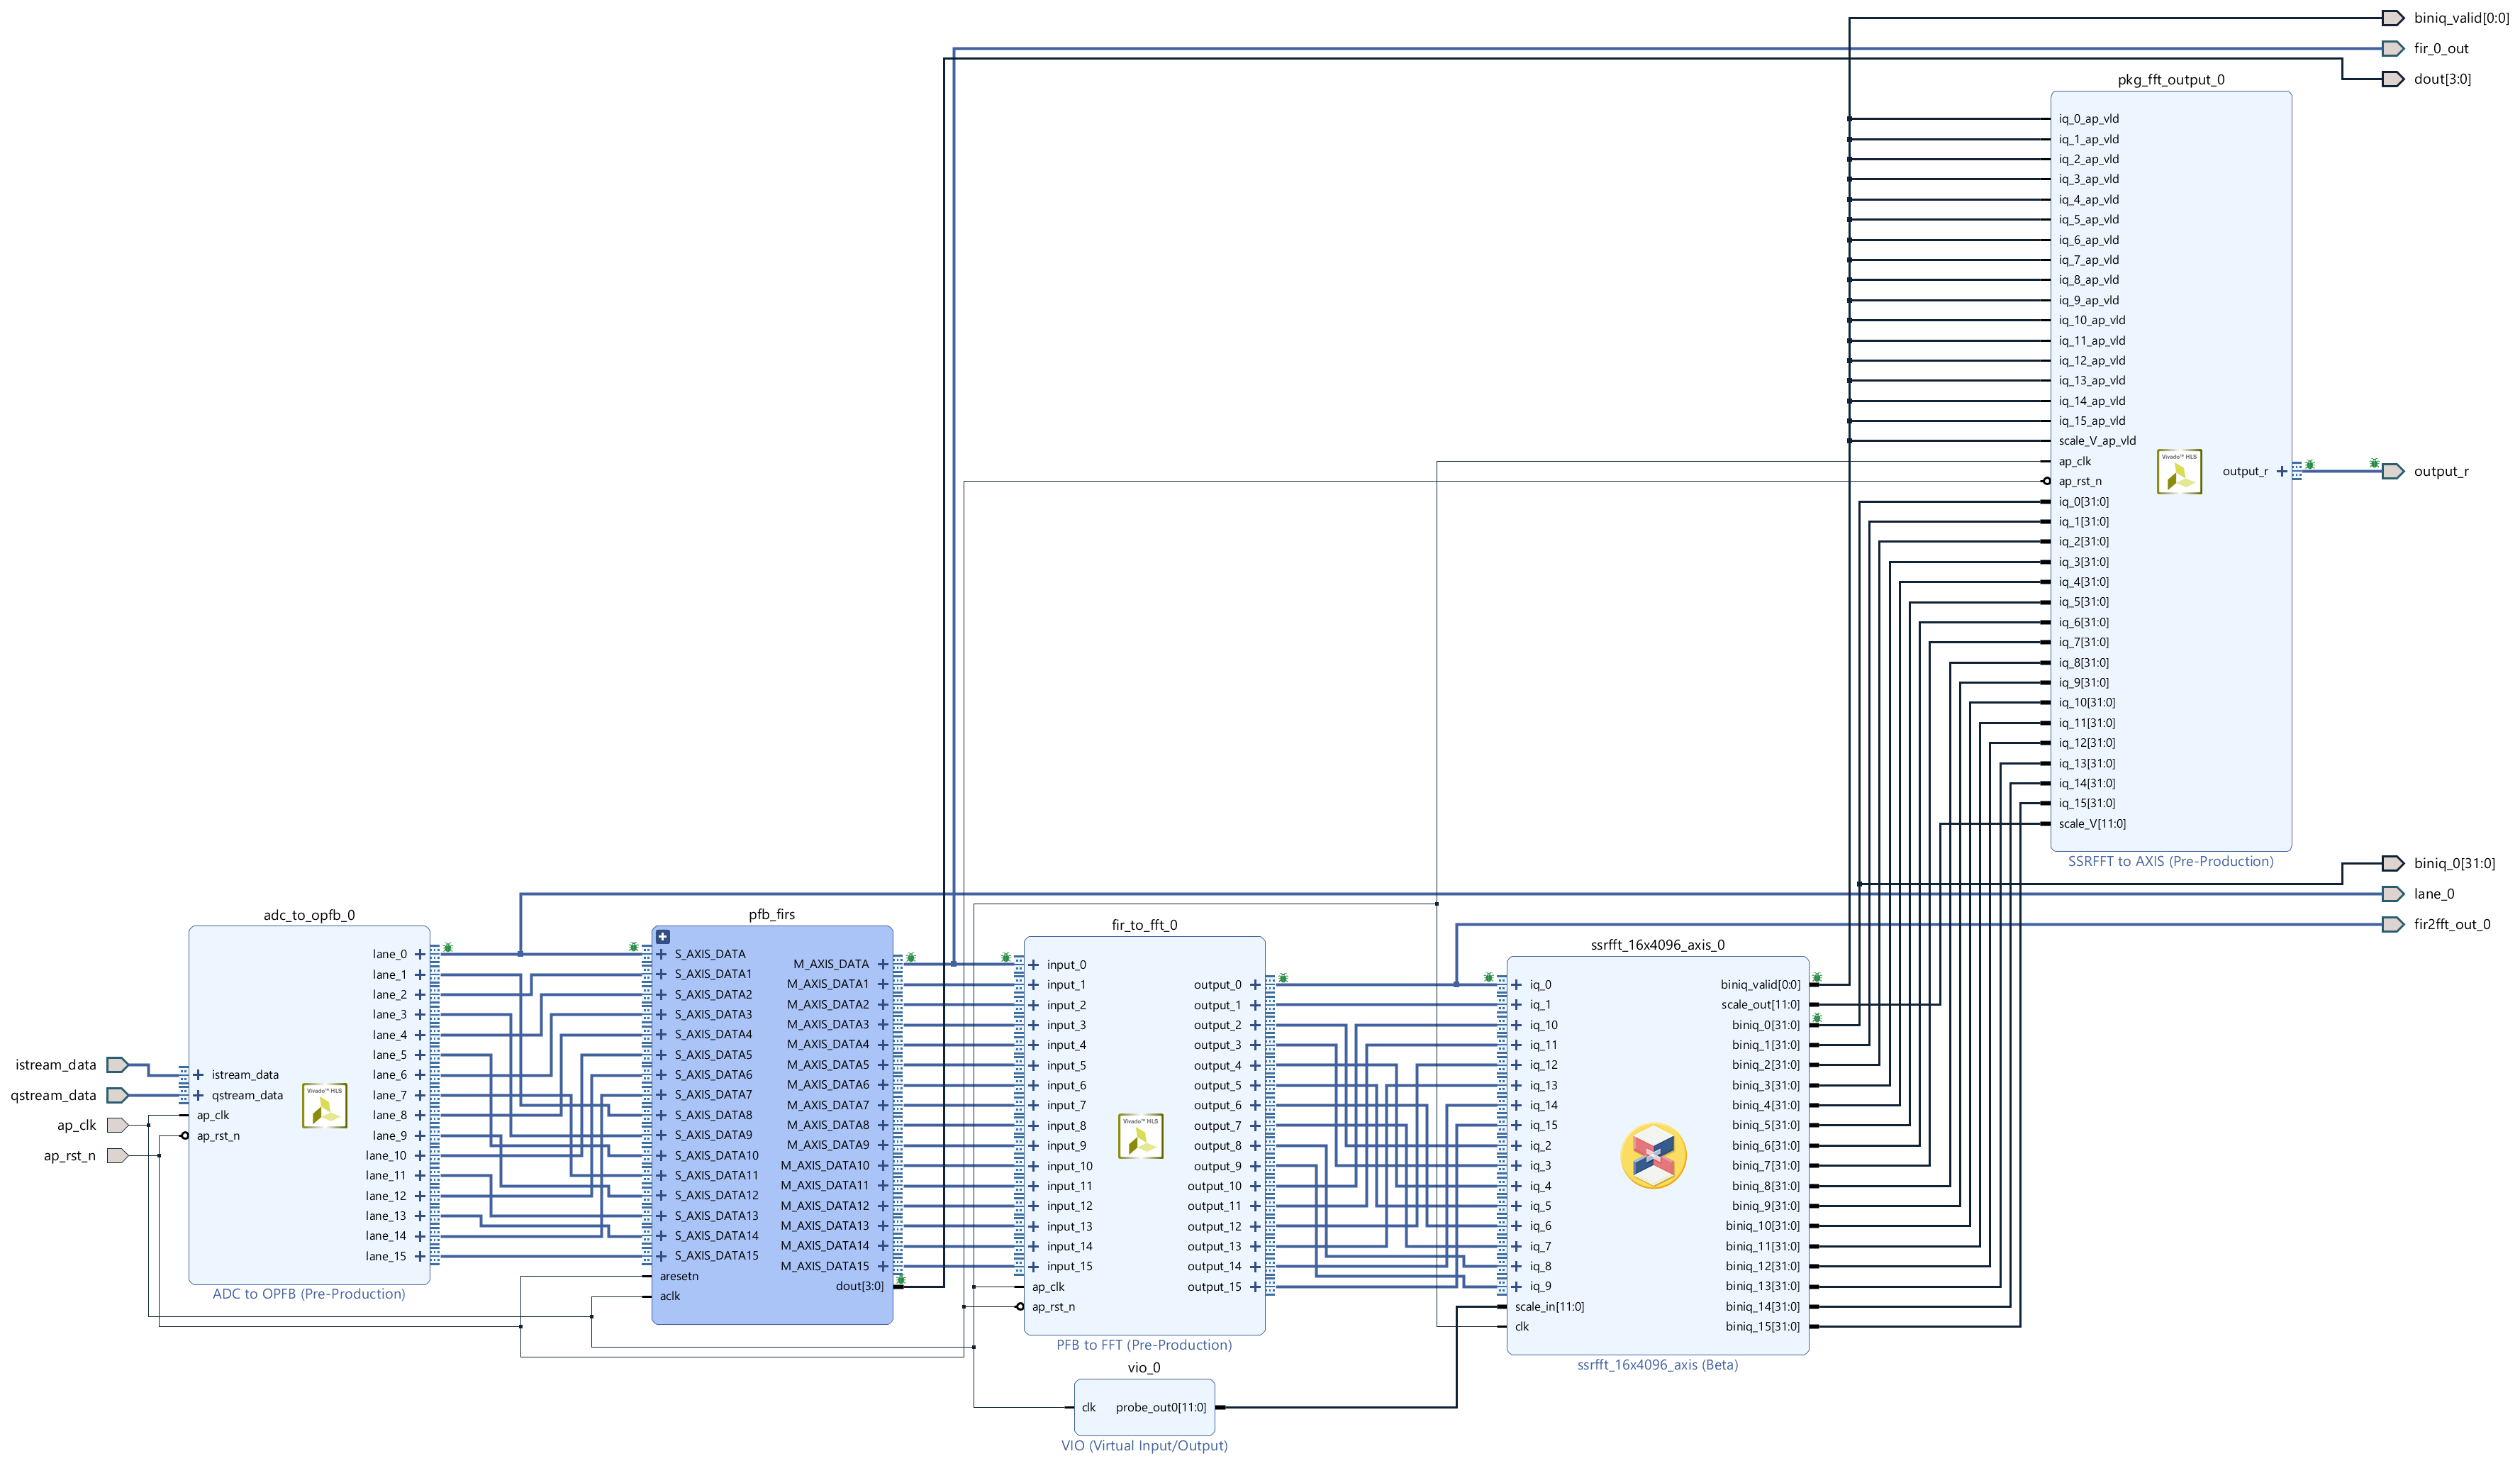

with a bank of FIRs 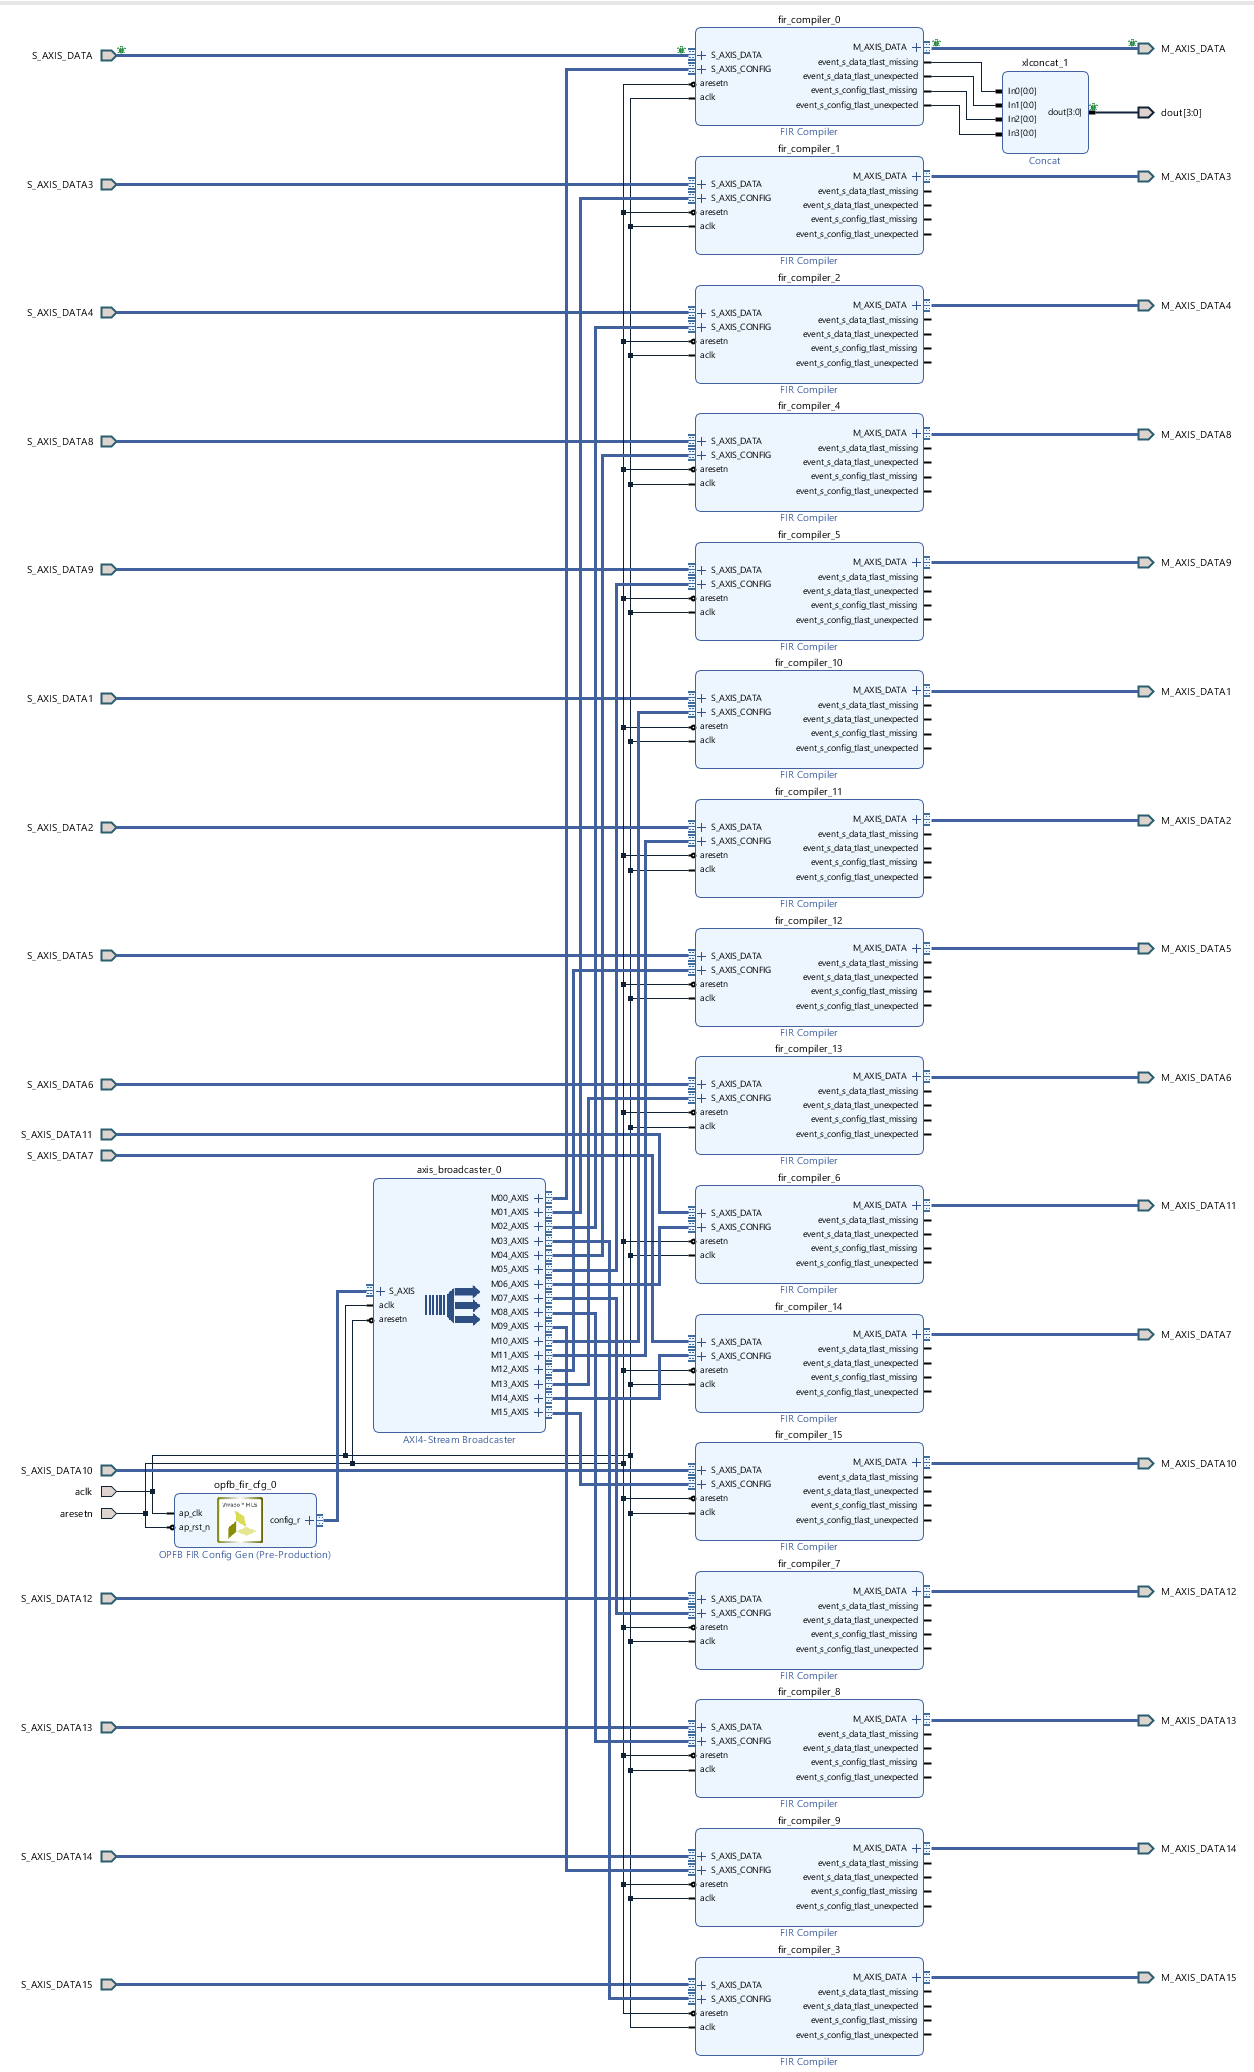

and a SysGen FFT design 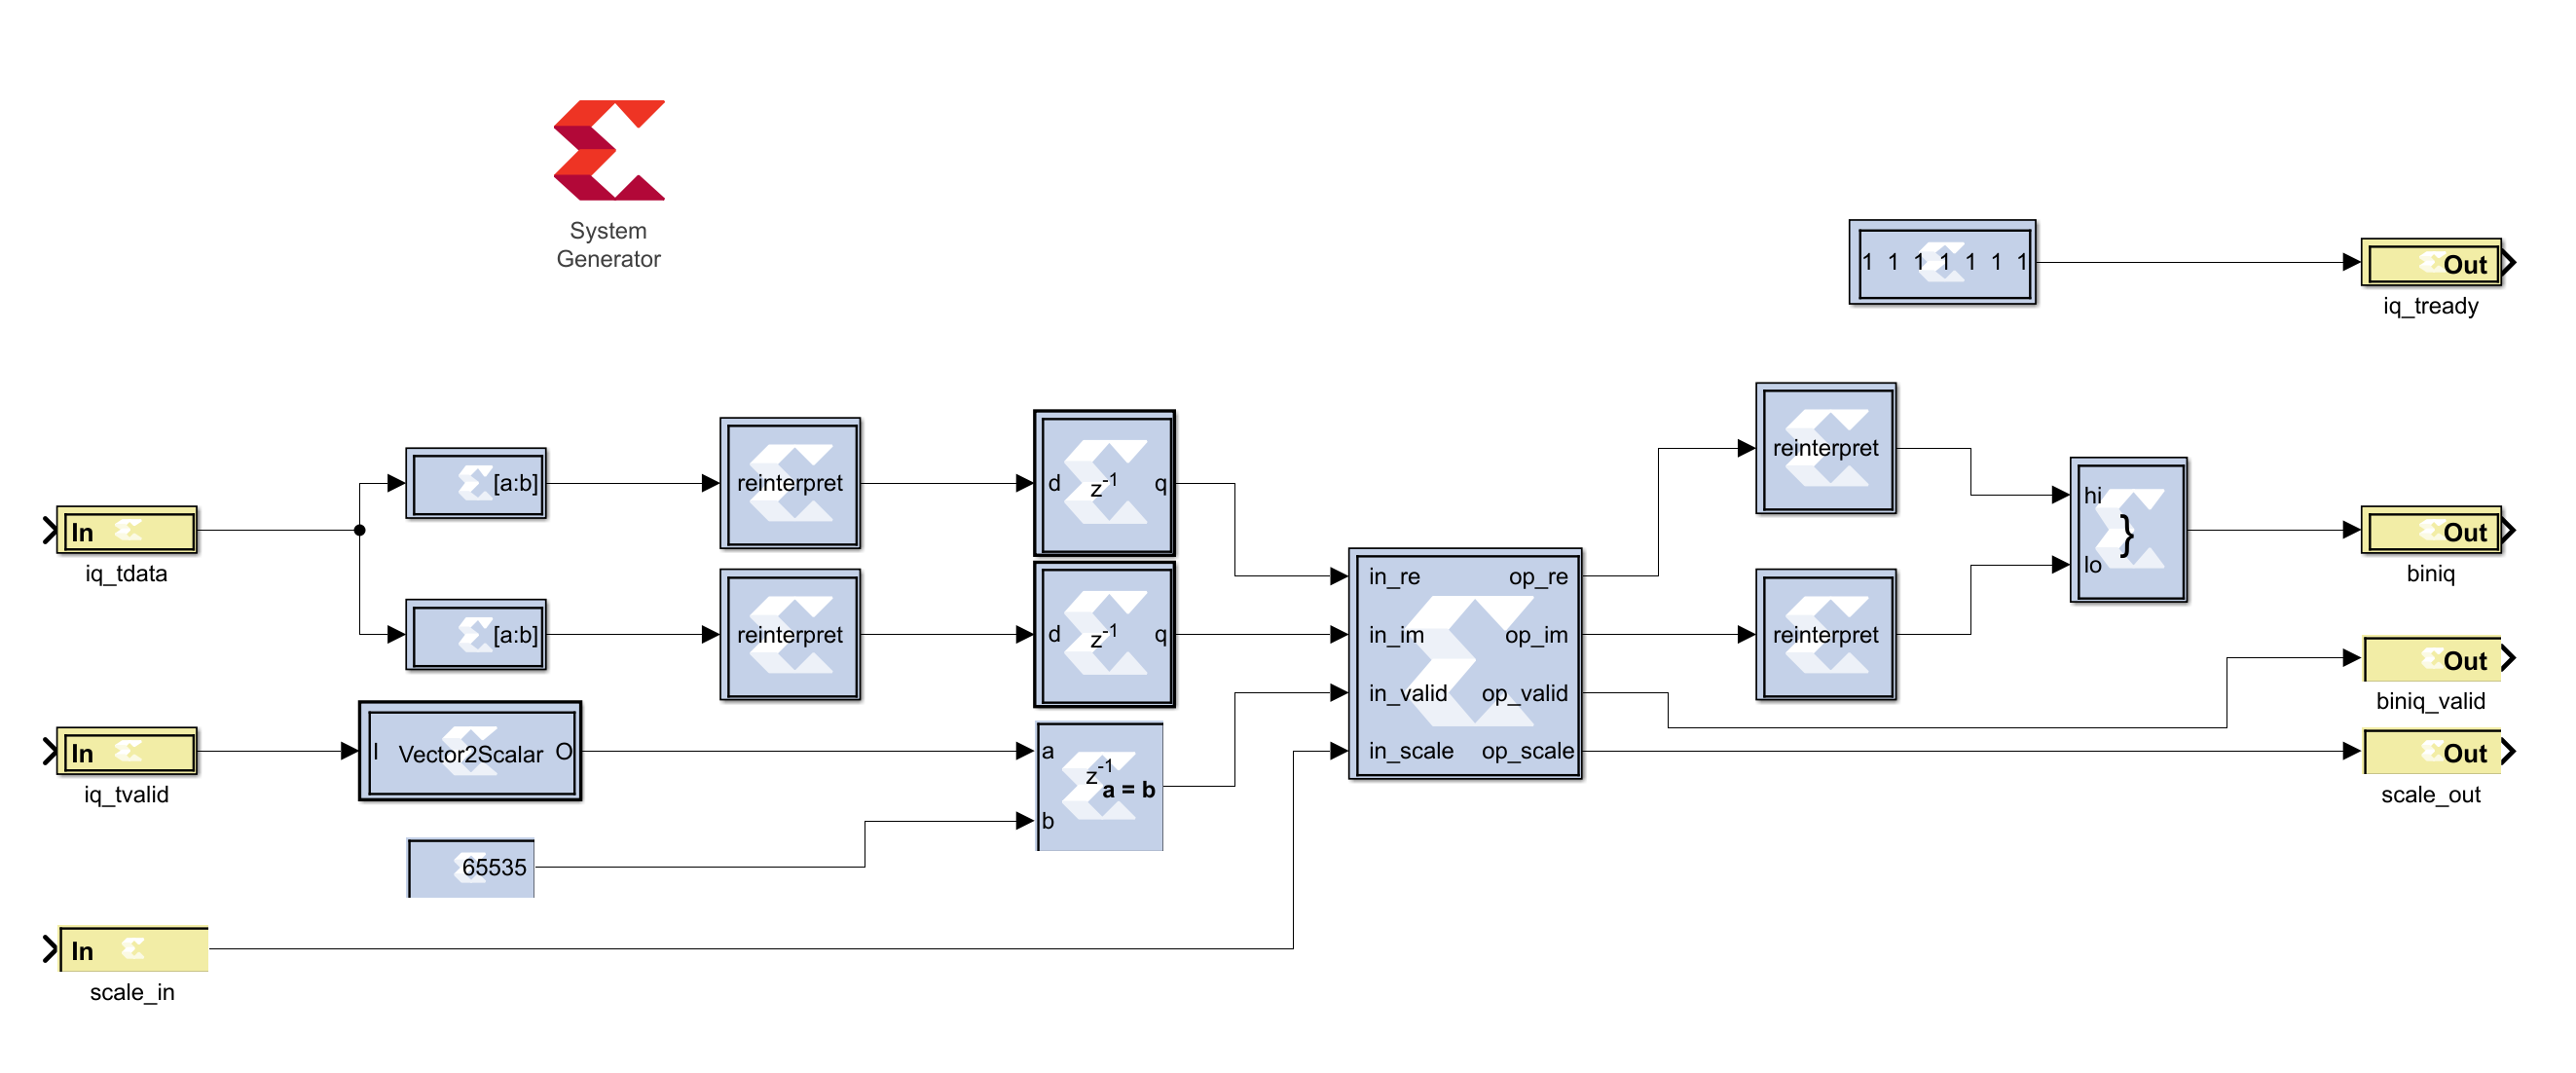

## 1. Imports, definitions, and Instantiating the overlay

In [1]:
from mkidgen3.daccomb import generate as gen_comb
from mkidgen3.pynq import dma_status  ## also activates the drivers
import logging
import numpy as np
import time
import pynq
from pynq import PL
from pynq import Overlay
from pynq import DefaultIP
from pynq import allocate
from fpbinary import FpBinary, OverflowEnum, RoundingEnum

import matplotlib.pyplot as plt

logging.basicConfig()

n_res = 2048
n_bin = 4096

n_packets_rcvd, n_packets_sent = 0, 0

We've had some issues with unexpected ZCU111 hangs and this was suggesting as a stabilizing measure on the PYNQ forums. This configuration is designed to enable timeouts for PS/PL AXI connnections.

In [2]:
mmio  = pynq.MMIO(0xFD610000 , 64)
mmio.write(0x18, 7) # Return slave errors when timeouts occur
mmio.write(0x20, 0x1020) # Set and enable prescale of 32 which should be about 10 ms
mmio.write(0x10, 0x7) # Enable transactions tracking
mmio.write(0x14, 0x7) # Enable timeouts

Load the overlay and extract the dma core

In [3]:
ol = Overlay('/home/xilinx/overlayfiles/opfb/opfb.bit')
ol.download()
dma = ol.axi_dma_0
print(f"PL Bitfile: {PL.bitfile_name}\nPL Timestamp: {PL.timestamp}\n"
      f"Overlay timestamp: {ol.timestamp}  Loaded: {ol.is_loaded()}")
dma_status(dma)

PL Bitfile: /home/xilinx/overlayfiles/opfb/opfb.bit
PL Timestamp: 2020/3/5 0:1:55 +313214
Overlay timestamp: 2020/3/5 0:1:55 +313214  Loaded: True
DMA:
 MM2s
 Idle:False
 MM2S_DMASR (status):0x0
 MM2S_SA (ptr) :0x0
 MM2S_LENGTH (len):0
 S2MM
 Idle:False
 S2MM_DMASR (status):0x0
 S2MM_DA (ptr) :0x0
 S2MM_LENGTH (len):0


## Reading and writing DMA

Prepare some functions to convert numpy data to and from the correct data format.

Keep in mind the cores are based around 256 groups of 8 or 16 samples which are either 2 or 4 bytes depending on if they are complex or not. We are sending in a 256 bit stream that will be split into 128 low (I) and 128 high bits (Q), each consisting of 8 16 bit numbers. The TLAST of the DMA serves as a trigger to the large stream fifo in the OL in packet mode to trigger streaming though the core (data doesn't flow until the DMA write is done). The adc2opfb core will provide a tlast for the pipeline every 256 stream beats. This propagates through and flows into a large non-packet-mode stream FIFO that sources DMA reads, which therefore must correspond to 256 output beats to get a proper tlast.

The output stream is similar to the input, though it consists of groups of 16 numbers due to the oversampling (512 bits, 2x256. Essentially 16 `complex<ap_fixed<16,15>>`.

Some other points to know:
- The adc2opfb gives a tlast every packet.
- The FIR cores give a tlast every two packets.
- The fir2fft core gives a tlast every packet.
- The fft keeps moving data through it with a latency of either 816 or 817.
- The fft2axi core gives a tlast every packet. If TREADY is low it will drop the FFT outputs from those cycles.

### Create functions to help mode the data

A pair to convert to and from floating point

In [4]:
def packet_to_buffer(packet):
    """packet should be an np.array(n_res*n, dtype=np.complex64/128) where n is an integer"""
    ibits=[FpBinary(int_bits=1, frac_bits=15, signed=True, value=x).__index__() for x in packet.real]
    qbits=[FpBinary(int_bits=1, frac_bits=15, signed=True, value=x).__index__() for x in packet.imag]
    data=np.zeros(2*packet.size, dtype=np.uint16)
    for i in range(8):
        data[i::16] = ibits[i::8]
        data[i+8::16] = qbits[i::8]
    return data

def packet_from_buffer(buffer):
    ibits=np.zeros(buffer.size//2, dtype=np.uint16)
    qbits=np.zeros(buffer.size//2, dtype=np.uint16)
    for i in range(8):
        ibits[i::8]=buffer[i::16]
        qbits[i::8]=buffer[i+8::16]
    
    packet=np.zeros(buffer.size//2, dtype=np.complex64)
    packet.real=[float(FpBinary(int_bits=1, frac_bits=15, signed=True, bit_field=int(x))) for x in ibits]
    packet.imag=[float(FpBinary(int_bits=1, frac_bits=15, signed=True, bit_field=int(x))) for x in qbits]

    return packet

One to receive multiple packets (use some globals we will define later)

In [5]:
def rxpackets(n, status=False):
    global n_packets_rcvd
    for i in range(n):
        if status:
            print(f"Receiving {pprx} packet(s) starting with {n_packets_rcvd}")
        dma.recvchannel.transfer(output_buffer)
        dma.recvchannel.wait()
        converted=np.array([packet_from_buffer(x) for x in output_buffer.reshape(1, n_bin*2)])
        packets_out[n_packets_rcvd:n_packets_rcvd+1]=converted
        n_packets_rcvd+=1

One to flush the pipeline

In [6]:
def flush(n=32):
    global n_packets_sent,n_packets_rcvd
    input_buffer[:]=0
    for i in range(0):
        dma.sendchannel.transfer(input_buffer)
        dma.sendchannel.wait()
        n_packets_sent+=pptx
        rxpackets(int(input_buffer.size/output_buffer.size*2))  #output is twice as large per packet
    n_packets_sent,n_packets_rcvd=0,0

## Generate and feed a stream

Both the resonator packets and the downconverted packets are $8kB = 256~cycles \cdot256~bits/cycle$, probably I0I1...I7Q0...Q7. So that is 4096 16 bit numbers, note that operations like input_buffer[5:]=999 will kill the kernel (at least sometimes)!

We need to send two packets  to ensure we drive the last transfer of the first packet all the way through the core (the core latency is ~30).

input_buffer = allocate(shape=(n_res*2,), dtype=np.uint16)
output_buffer = allocate(shape=(n_res*2,), dtype=np.uint16)

First create a timeseries of IQ values for a bin in it.
A 1Hz signal would have 2M samples



### What settings

In [7]:
n_total_packets=128*10           #How many packets
n_samples=256*n_total_packets*8  #How many waveform samples do we need to generate
sample_rate=4.096e9
FFT_LENGTH = n_bin            # transform size in pfb (a.k.a polyphase branches)
M = n_bin                     # polyphase branhces
P = 8                         # filter taps per polyphase branch
D = n_res                     # decimation rate, (D < M)
fs_cs = sample_rate/M         # critically sampled output sample rate
fs_os = sample_rate/D         # oversampled output sample rate
offset = 2*P-1                # wait 2P-1 windows for valid outpts (filter wind up effect)

OUTPUT_WINDOWS = n_total_packets   # number of output samples per polyphase branch after simulation
nsamps = M*OUTPUT_WINDOWS          # number of generated data samples

# 2nd stage channelizer parameters
OUTPUT_FFT_LENGTH = 1024               # second stage transform size  2MHz/1024 ~2kHz, must be < n_total_packets-16
hsov = (M-D)*OUTPUT_FFT_LENGTH//(2*M)  # half-sided overlap, number of channels discared at one band edge
n_fine_channels = D*OUTPUT_FFT_LENGTH  # Number of channels 2nd second stage (after discarding redundant channels)


print(f"fs_cs: {fs_cs/1e6} MHz fs_os: {fs_os/1e6} MHz nsamps:{nsamps}\n"
      f"hsov: {hsov} offset:{offset} n_fine_channels:{n_fine_channels}")

fs_cs: 1.0 MHz fs_os: 2.0 MHz nsamps:5242880
hsov: 256 offset:15 n_fine_channels:2097152


### Prepare the Data

What tones we want to send?

In [8]:
freq=np.array([-300, 100, 151, 1000.5])*1e6  # -2048-2047
amplitudes = np.ones_like(freq)/2048
phases=np.zeros_like(freq)

Generate the complex waveform

In [12]:
t = 2 * np.pi * np.arange(n_samples)/sample_rate
comb=np.zeros(n_samples, dtype=np.complex64)
for i in range(freq.size):
    comb += amplitudes[i] * np.exp(1j * (t * freq[i] + phases[i]))
comb=comb.reshape(comb.size//n_res, n_res)
print(f"Comb shape: {comb.shape}. \nTotal Samples: {comb.size}. Memory: {comb.size*8/1024**2:.0f} MB\n"
      f"Max value: {np.abs(comb).max()}.\n"
      f"Expected tone amplitude factor: ~512 * N_TONES_IN_BIN. (4096/8 as FFT scale dfaults to 8 in last 3 stages)\n"
      f"Resulting samples per output bin: {comb.size*2/n_bin}")

Comb shape: (1296, 2048). 
Total Samples: 2654208. Memory: 20 MB
Max value: 0.001953125.
Expected tone amplitude factor: ~512 * N_TONES_IN_BIN. (4096/8 as FFT scale dfaults to 8 in last 3 stages)
Resulting samples per output bin: 1296.0


Plot an FFT of the first full timeseries

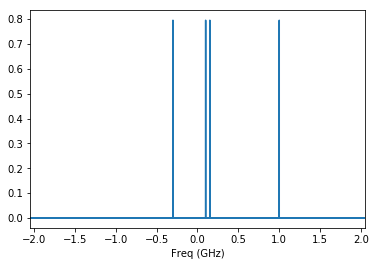

In [11]:
plt.plot(np.fft.fftfreq(comb.size, d=1/4.096e9)/1e9, 
         np.abs(np.fft.fft(comb.ravel(), norm='ortho')))
plt.xlim(-sample_rate/2e9,sample_rate/2e9);
plt.xlabel('Freq (GHz)');

### Prepare an output array

In [13]:
packets_out=np.zeros((comb.shape[0], n_bin), dtype=np.complex64)

### Prepare DMA buffers

In [14]:
pptx=16  # How many packets do we send per DMA transfer. Must be <=16 to move the stream smoothly through the core

#Close buffers if they are open
try:
    input_buffer.close()
    output_buffer.close()
except NameError:
    pass

#Create the buffers
input_buffer = allocate(shape=(n_res*2*pptx,), dtype=np.uint16)  #2048 I & Q
output_buffer = allocate(shape=(n_bin*2,), dtype=np.uint16)

### Send the data
This takes a while

In [15]:
for i in range(n_total_packets//pptx):
    input_buffer[:]=np.array([packet_to_buffer(p) for p in comb[n_packets_sent:n_packets_sent+pptx]]).ravel()
    dma.sendchannel.transfer(input_buffer)
    dma.sendchannel.wait()
    n_packets_sent+=pptx
    rxpackets(pptx)
    print(f"Sent: {n_packets_sent} Received: {n_packets_rcvd}. Pending: {n_packets_sent-n_packets_rcvd}")

Sent: 16 Received: 16. Pending: 0
Sent: 32 Received: 32. Pending: 0
Sent: 48 Received: 48. Pending: 0
Sent: 64 Received: 64. Pending: 0
Sent: 80 Received: 80. Pending: 0
Sent: 96 Received: 96. Pending: 0
Sent: 112 Received: 112. Pending: 0
Sent: 128 Received: 128. Pending: 0
Sent: 144 Received: 144. Pending: 0
Sent: 160 Received: 160. Pending: 0
Sent: 176 Received: 176. Pending: 0
Sent: 192 Received: 192. Pending: 0
Sent: 208 Received: 208. Pending: 0
Sent: 224 Received: 224. Pending: 0
Sent: 240 Received: 240. Pending: 0
Sent: 256 Received: 256. Pending: 0
Sent: 272 Received: 272. Pending: 0
Sent: 288 Received: 288. Pending: 0
Sent: 304 Received: 304. Pending: 0
Sent: 320 Received: 320. Pending: 0
Sent: 336 Received: 336. Pending: 0
Sent: 352 Received: 352. Pending: 0
Sent: 368 Received: 368. Pending: 0
Sent: 384 Received: 384. Pending: 0
Sent: 400 Received: 400. Pending: 0
Sent: 416 Received: 416. Pending: 0
Sent: 432 Received: 432. Pending: 0
Sent: 448 Received: 448. Pending: 0
Sent

In [16]:
import time
np.savez(f"packets_out_{time.time()}.npz",  
         freq=freq, phases=phases, amplitudes=amplitudes,
         packets_out=packets_out)

### Look at the results

In [ ]:
with np.load("packets_out_1583310969.8077557.npz") as d:
    packets_out=d['packets_out']
    freq=d['freq']
    phases=d['phases']
    amplitudes=d[amplitudes']

In [ ]:
offset=16

Plot the average bin output

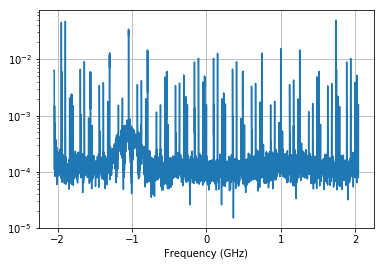

In [18]:
# plot coarse channel output
plt.plot((np.arange(FFT_LENGTH)*fs_cs-sample_rate/2)/1e9, np.mean(np.abs(packets_out[offset:,:]),0))
plt.semilogy()
plt.xlabel('Frequency (GHz)')
plt.grid()
plt.show()

Compute an FFT of each bin and stitch the results together. TODO: This code is probably not quite right

In [19]:
# second stage FFT fine spectrum output
fine_spectrum_matrix = np.fft.fftshift(np.fft.fft(packets_out[offset:(OUTPUT_FFT_LENGTH+offset), :],
                                            OUTPUT_FFT_LENGTH, axis=0), axes=(0,)).astype(np.complex64)
fine_spectrum_matrix/=OUTPUT_FFT_LENGTH
# discard redundant channels
fine_spectrum = fine_spectrum_matrix[(hsov-1):-(hsov+1), :].reshape(n_fine_channels)

Generate a list of the first 32 bins either with a tone or adjacent to a bin with a tone and plot them. If fewer than 32, just plot the last bins. TODO

<IPython.core.display.Javascript object>


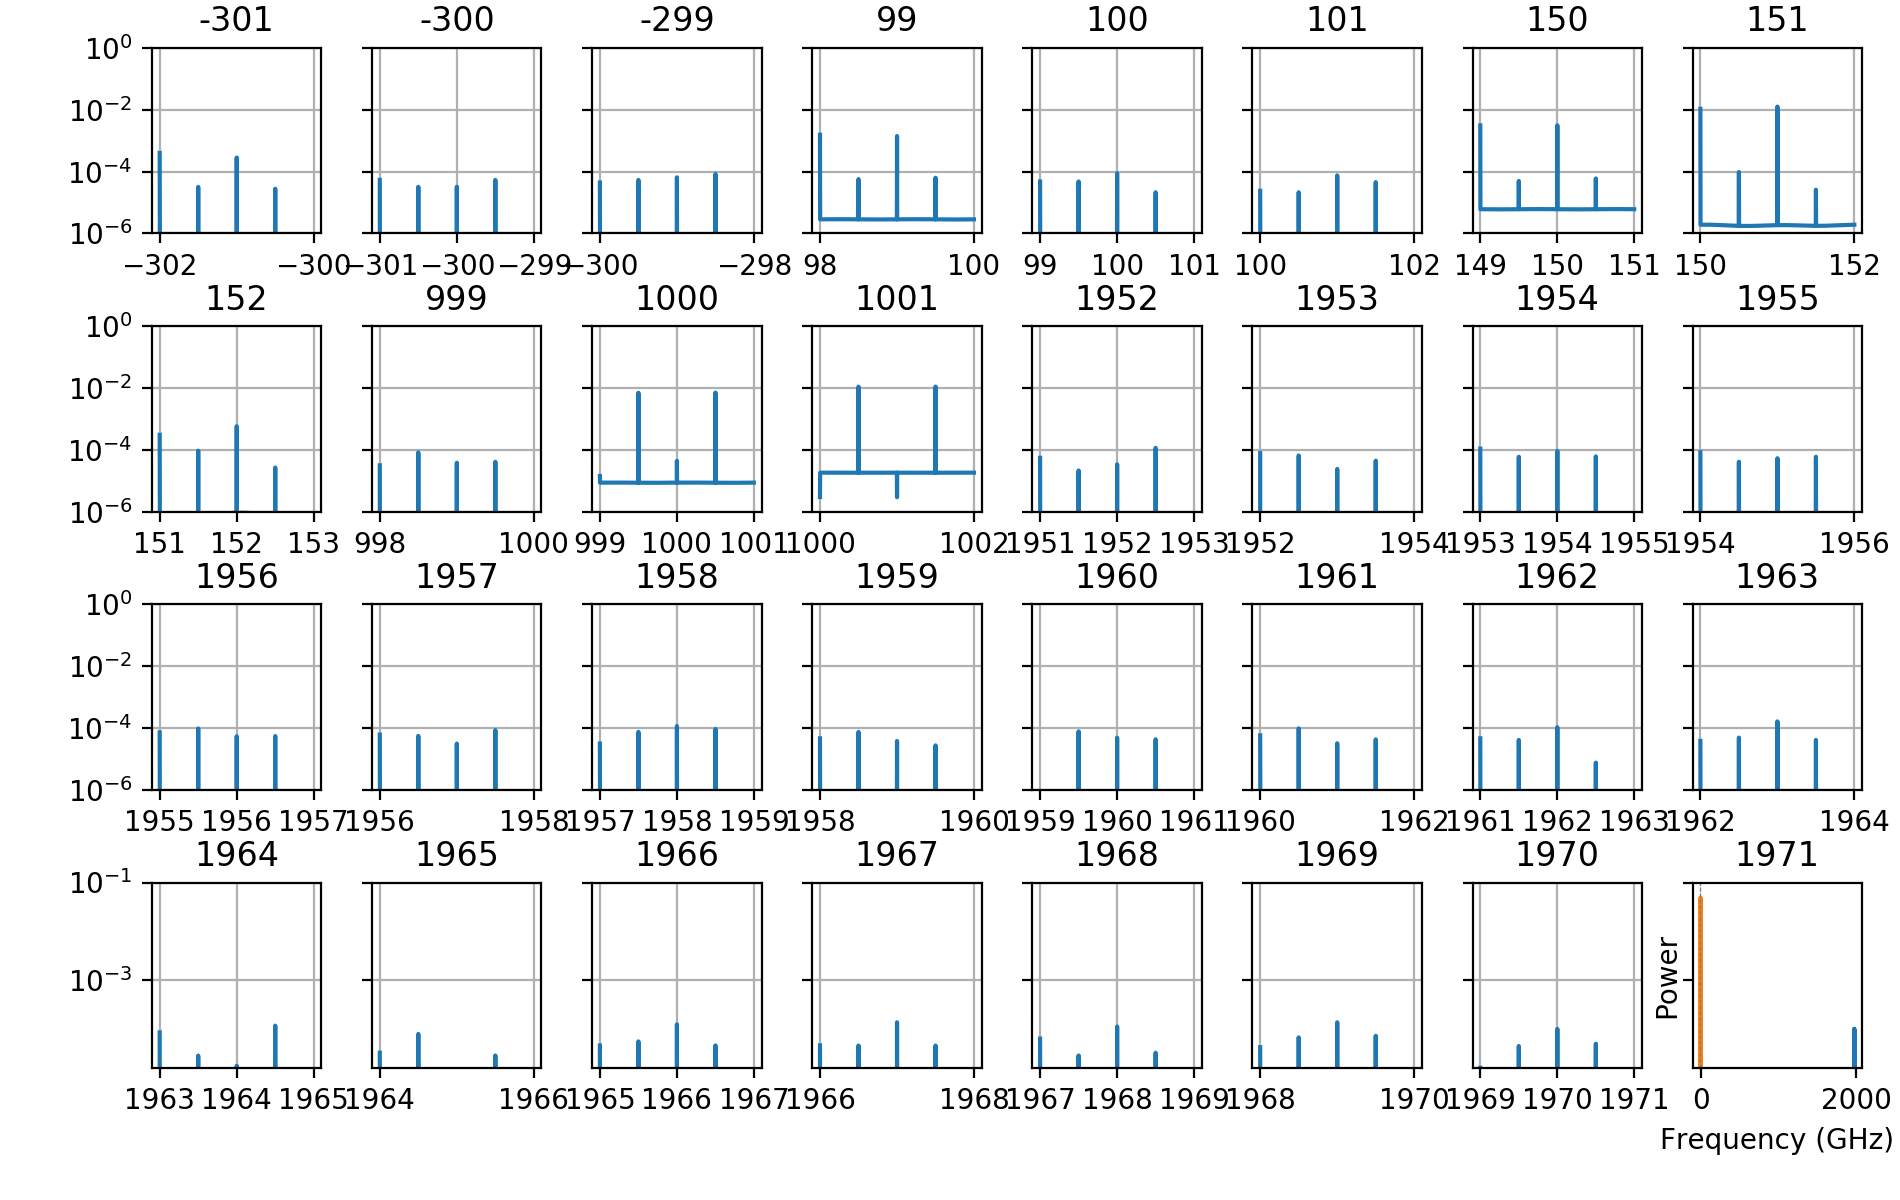

In [49]:
fig, ax = plt.subplots(4,8, sharey='row', figsize=(9.5,6))

#Build a list of bins to plot based on the frequencies
bins_to_plot = list(set(list((np.round(freq/1e6+2048).astype(int)-1).clip(0))+
                   list(np.round(freq/1e6+2048).astype(int))+
                   list((np.round(freq/1e6+2048).astype(int)+1).clip(0,4095))))
bins_to_plot = sorted(list(set(bins_to_plot+list(range(4095,4000,-1)))))[:32]

for i in range(32):
        m = bins_to_plot[i]
        # this shift corrects for overlap between adjacent bins 
        bin_shift = - ((OUTPUT_FFT_LENGTH//2) + m*2*hsov)
        subbins = np.arange(m*OUTPUT_FFT_LENGTH, (m+1)*OUTPUT_FFT_LENGTH) + bin_shift
        plt.sca(ax.flat[i])
        plt.title(f"{m-2048}")
        plt.locator_params(numticks=2)
        plt.plot(subbins*fs_os/OUTPUT_FFT_LENGTH/1e6-2048, np.abs(fine_spectrum_matrix[:,m]))
        plt.ylim(1e-6, 1)
        plt.semilogy()
        plt.grid(True)
plt.subplots_adjust(left=.08,right=.98, top=.96, hspace=.5, wspace=.3)
plt.show()

Generate a stitched plot of the output spectrum. TODO

<IPython.core.display.Javascript object>


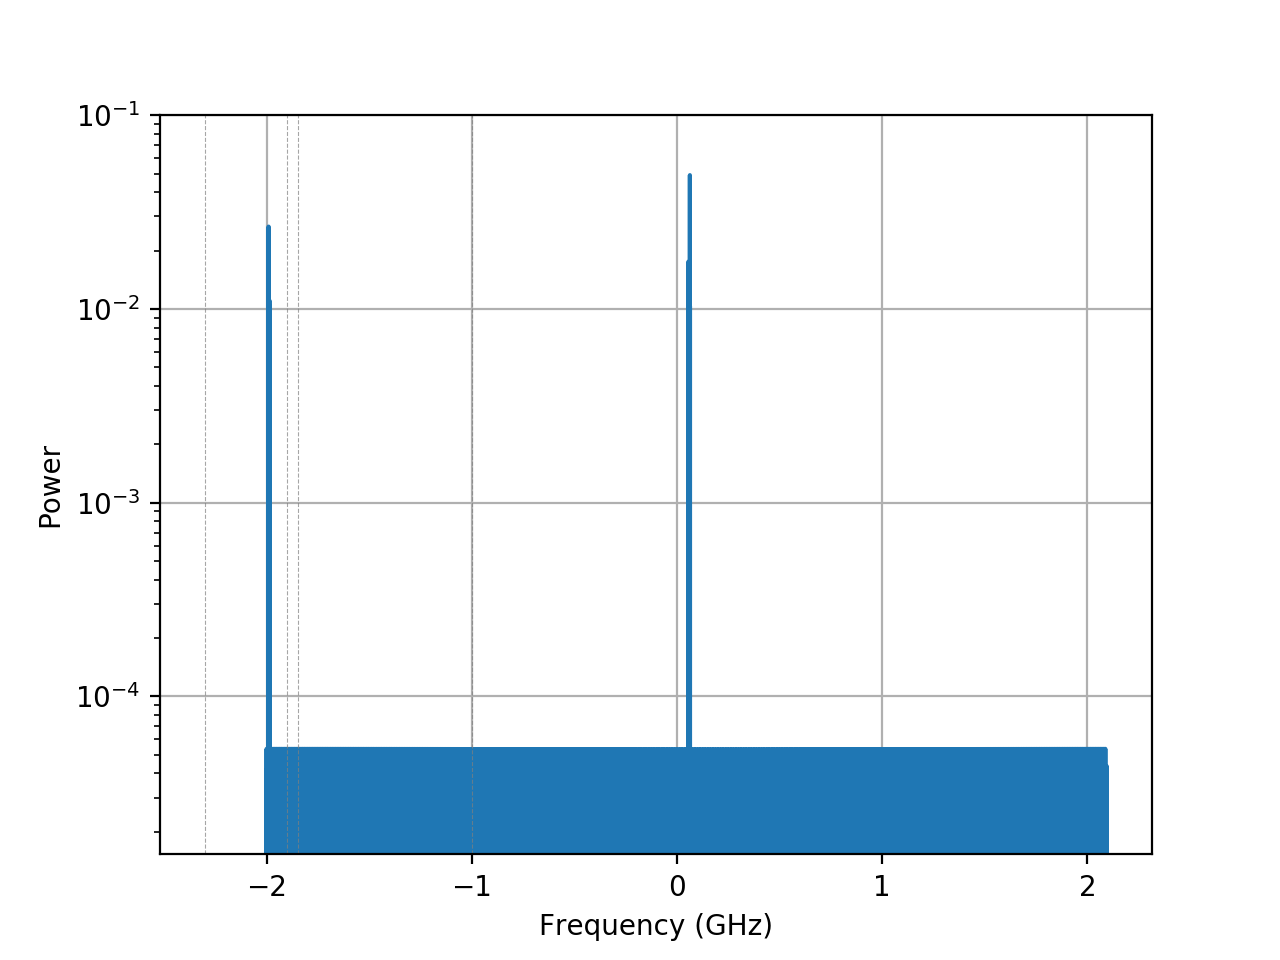

In [51]:
# plot fine spectrum
plt.figure()
fshift = -(OUTPUT_FFT_LENGTH/2-hsov+1)
fbins_fine = np.arange(n_fine_channels) + fshift
faxis_fine = fbins_fine*fs_os/OUTPUT_FFT_LENGTH/1e9-2
plt.plot(faxis_fine, np.abs(fine_spectrum))
plt.semilogy()
#plt.xlim([min(faxis_fine), max(faxis_fine)])
plt.xlabel('Frequency (GHz)')
plt.ylabel('Power')
for f in freq:
    plt.axvline(f/1e9-2, color='grey', alpha=.7, linestyle='--', linewidth=.4)
plt.grid()
plt.ylim(1/2**16,.1);
#plt.ylim(20*np.log10(1/2**15)-10,0);  #limit to 10 below the quantization floor
#plt.xlim(-2.048,2.048);  

In [27]:
%matplotlib notebook